# Deep Reinforcement Learning - Assignment 2
## Training and Comparing REINFORCE Agents on CartPole-v1

This notebook implements, trains, and evaluates Policy Gradient agents.

### Assignment Structure:
- **Section 1**: Vanilla REINFORCE Agent
- **Section 2**: REINFORCE with Baseline (Value Function)
- **Section 3**: One step Actor-Critic
- **Section 4**: Comparison and Analysis

---

In [ ]:
# Setup: Add project root to Python path
import os
import sys

# Get the notebook's directory
notebook_dir = os.path.abspath('')
project_root = notebook_dir  # Since notebook is in project root

# Add to path if not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root: {project_root}")

Project root: c:\Users\yonat\CodeProjects\DRL\Assignment2


In [ ]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any
from datetime import datetime
import random
import importlib

# Gymnasium
import gymnasium as gym

# PyTorch
import torch

# Disable PyTorch 2.0+ compilation features that might cause issues
torch._dynamo.config.suppress_errors = True
import torch._dynamo
torch._dynamo.disable()

# Force complete module reload
import sys
modules_to_remove = [key for key in list(sys.modules.keys()) 
                    if 'agent' in key.lower() or 'src' in key or 'utils' in key or 'ffnn' in key]
for module in modules_to_remove:
    del sys.modules[module]

# Import custom modules
import src.utils
import src.ffnn
import src.agent

# Reload to get latest changes (run this cell again after editing source files)
importlib.reload(src.utils)
importlib.reload(src.ffnn)
importlib.reload(src.agent)

# Import agents from reloaded module
from src.agent import ReinforceAgent, ReinforceBaselineAgent, ActorCriticAgent

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- SEED SETTING ---
SEED = 42
def set_seeds(seed=SEED, env=None):
    """Set seeds for reproducibility across numpy, random, torch, and gym."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
    if env is not None:
        env.action_space.seed(seed)
        env.reset(seed=seed)
        print(f"✓ Environment seeded with {seed}")

set_seeds()
print(f"✓ Global seeds set to {SEED}")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ Modules reloaded successfully")

✓ Global seeds set to 42
✓ PyTorch version: 2.9.1+cpu


## Helper Functions

In [3]:
def plot_training_metrics(results: Dict[str, Any], agent_name: str, save_path: str = None):
    """Plot rewards and losses."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Rewards
    rewards = results['rewards']
    window = 100
    axes[0].plot(rewards, alpha=0.6, label='Episode Reward')
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        axes[0].plot(np.arange(window-1, len(rewards)), moving_avg, color='red', linewidth=2, label='100-Ep Avg')
    
    axes[0].axhline(y=475, color='green', linestyle='--', label='Target (475)')
    axes[0].set_title(f'{agent_name}: Rewards')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Reward')
    axes[0].legend()
    
    # Loss
    if results['loss']:
        axes[1].plot(results['loss'], color='orange', alpha=0.6)
        axes[1].set_title(f'{agent_name}: Loss')
        axes[1].set_xlabel('Episode')
        axes[1].set_ylabel('Loss')
    
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
    plt.show()

def save_results(agent, results, name, base_dir="models"):
    """Save model weights and results."""
    os.makedirs(base_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save model state dict
    torch.save(agent.policy_net.state_dict(), f"{base_dir}/{name}_{timestamp}_policy.pth")
    if hasattr(agent, 'value_net'):
        torch.save(agent.value_net.state_dict(), f"{base_dir}/{name}_{timestamp}_value.pth")
        
    # Save metrics
    np.savez(f"{base_dir}/{name}_{timestamp}_results.npz", **results)
    print(f"✓ Saved {name} to {base_dir}/")

## Environment Setup

In [5]:
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

print(f"State Dim: {state_dim}, Action Dim: {action_dim}")

State Dim: 4, Action Dim: 2


---
# Section 1: Vanilla REINFORCE

In [6]:
# Configuration
config_reinforce = {
    'gamma': 0.99,
    'learning_rate': 1e-3,  # Initial learning rate
    'hidden_dims': [64, 64]  # Sufficient for CartPole
}

# Initialize Agent
set_seeds(SEED, env) # Reset seeds for fair comparison
agent_reinforce = ReinforceAgent(state_dim, action_dim, config_reinforce)

print("Initialized Vanilla REINFORCE Agent")

✓ Environment seeded with 42
Initialized Vanilla REINFORCE Agent


In [7]:
# Train
print("Starting Training...")
results_reinforce = agent_reinforce.train(
    env, 
    max_episodes=3000, 
    target_reward=475.0, 
    window=100
)

print(f"Training finished. Converged: {results_reinforce['converged']}")

Starting Training...
Episode 50 | MA Reward (100 episodes): 24.34
Episode 50 | MA Reward (100 episodes): 24.34
Episode 100 | MA Reward (100 episodes): 28.95
Episode 100 | MA Reward (100 episodes): 28.95
Episode 150 | MA Reward (100 episodes): 40.57
Episode 150 | MA Reward (100 episodes): 40.57
Episode 200 | MA Reward (100 episodes): 82.48
Episode 200 | MA Reward (100 episodes): 82.48
Episode 250 | MA Reward (100 episodes): 160.45
Episode 250 | MA Reward (100 episodes): 160.45
Episode 300 | MA Reward (100 episodes): 207.43
Episode 300 | MA Reward (100 episodes): 207.43
Episode 350 | MA Reward (100 episodes): 241.93
Episode 350 | MA Reward (100 episodes): 241.93
Episode 400 | MA Reward (100 episodes): 327.65
Episode 400 | MA Reward (100 episodes): 327.65
Episode 450 | MA Reward (100 episodes): 337.42
Episode 450 | MA Reward (100 episodes): 337.42
Episode 500 | MA Reward (100 episodes): 354.95
Episode 500 | MA Reward (100 episodes): 354.95
Episode 550 | MA Reward (100 episodes): 275.78
Ep

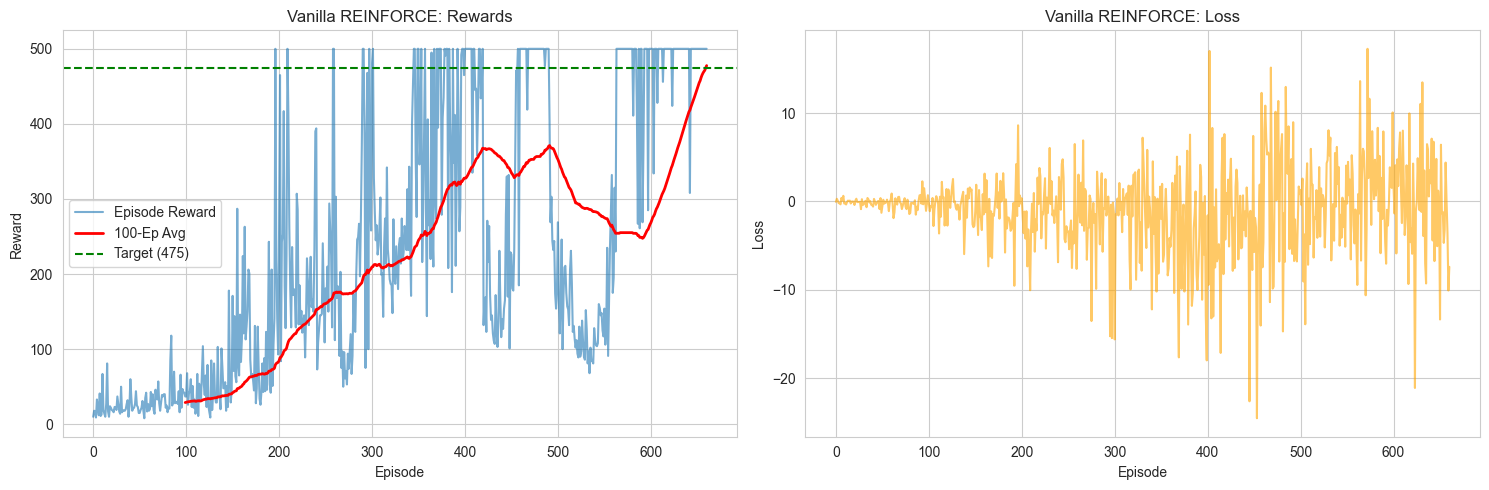

✓ Saved reinforce to models/


In [8]:
# Analyze
plot_training_metrics(results_reinforce, "Vanilla REINFORCE", "results/reinforce_training.png")
save_results(agent_reinforce, results_reinforce, "reinforce")

---
# Section 2: REINFORCE with Baseline

In [9]:
# Configuration - Separate learning rates for policy and value networks
config_baseline = {
    'gamma': 0.99,
    'learning_rate_policy': 5e-4,  # Actor LR (lower for stability)
    'learning_rate_value': 1e-3,   # Critic LR (higher for faster value learning)
    'hidden_dims_policy': [64, 64],
    'hidden_dims_value': [128, 64]  # Critic can be slightly larger
}

# Initialize Agent
set_seeds(SEED, env) # Reset seeds
agent_baseline = ReinforceBaselineAgent(state_dim, action_dim, config_baseline)

print("Initialized REINFORCE with Baseline Agent")

✓ Environment seeded with 42
Initialized REINFORCE with Baseline Agent


In [10]:
# Train
print("Starting Training...")
results_baseline = agent_baseline.train(
    env, 
    max_episodes=3000, 
    target_reward=475.0, 
    window=100
)

print(f"Training finished. Converged: {results_baseline['converged']}")

Starting Training...
Episode 50 | MA Reward (100 episodes): 30.82
Episode 50 | MA Reward (100 episodes): 30.82
Episode 100 | MA Reward (100 episodes): 61.38
Episode 100 | MA Reward (100 episodes): 61.38
Episode 150 | MA Reward (100 episodes): 138.34
Episode 150 | MA Reward (100 episodes): 138.34
Episode 200 | MA Reward (100 episodes): 261.56
Episode 200 | MA Reward (100 episodes): 261.56
Episode 250 | MA Reward (100 episodes): 346.39
Episode 250 | MA Reward (100 episodes): 346.39
Episode 300 | MA Reward (100 episodes): 381.21
Episode 300 | MA Reward (100 episodes): 381.21
Episode 350 | MA Reward (100 episodes): 347.60
Episode 350 | MA Reward (100 episodes): 347.60
Episode 400 | MA Reward (100 episodes): 365.96
Episode 400 | MA Reward (100 episodes): 365.96
Episode 450 | MA Reward (100 episodes): 447.42
Episode 450 | MA Reward (100 episodes): 447.42
Episode 500 | MA Reward (100 episodes): 466.67
Episode 500 | MA Reward (100 episodes): 466.67
Episode 550 | MA Reward (100 episodes): 469.8

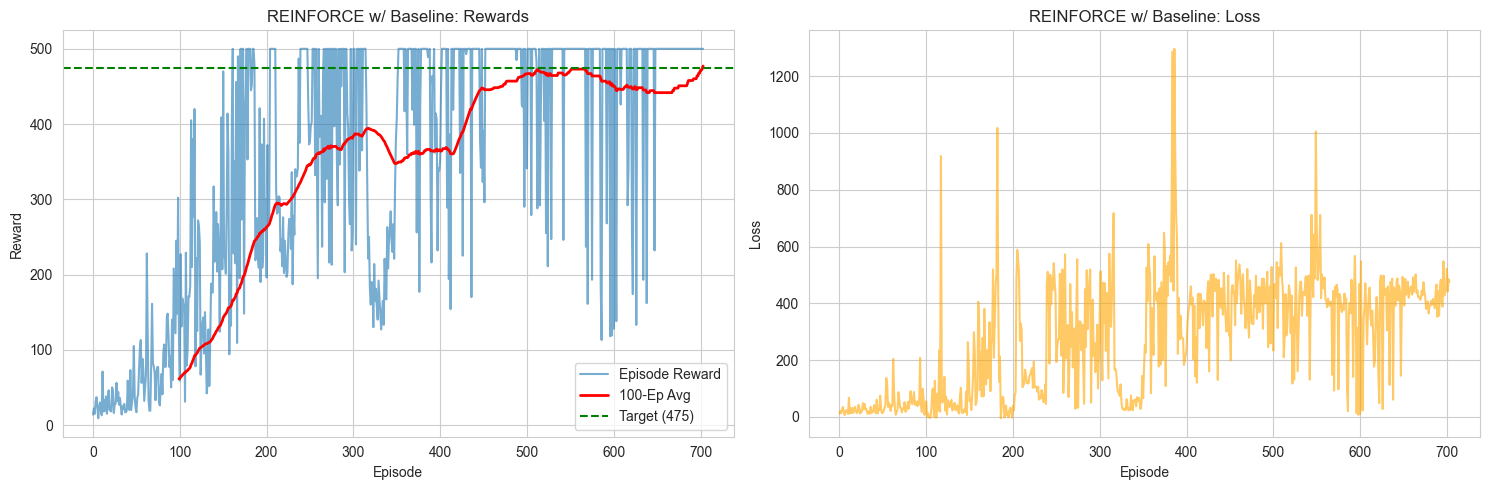

✓ Saved baseline to models/


In [11]:
# Analyze
plot_training_metrics(results_baseline, "REINFORCE w/ Baseline", "results/baseline_training.png")
save_results(agent_baseline, results_baseline, "baseline")

---
# Section 3: Advantage Actor-Critic (One-Step)

In [51]:
# Import custom modules
import importlib
import src.utils
import src.ffnn
import src.agent

# Reload to get latest changes (run this cell again after editing source files)
importlib.reload(src.utils)
importlib.reload(src.ffnn)
importlib.reload(src.agent)

# Import agents from reloaded module
from src.agent import ReinforceAgent, ReinforceBaselineAgent, ActorCriticAgent

In [55]:
# Configuration - tuned for stability
config_ac = {
    'gamma': 0.99,
    'learning_rate_actor': 1e-4,   # Slightly lower for stability
    'learning_rate_critic': 5e-4,  # Critic learns faster
    'entropy_beta': 0.01,          # Standard entropy
    'hidden_dims_actor': [128],
    'hidden_dims_critic': [128]
}

# Initialize Agent
set_seeds(SEED, env) # Reset seeds
agent_ac = ActorCriticAgent(state_dim, action_dim, config_ac)

print("Initialized Advantage Actor-Critic Agent")

✓ Environment seeded with 42
Initialized Advantage Actor-Critic Agent


In [56]:
# Train
print("Starting Training...")
results_ac = agent_ac.train(
    env, 
    max_episodes=1500, 
    target_reward=475.0, 
    window=100
)

print(f"Training finished. Converged: {results_ac['converged']}")

Starting Training...
Episode 50 | MA Reward (100 episodes): 15.30
Episode 50 | MA Reward (100 episodes): 15.30
Episode 100 | MA Reward (100 episodes): 12.63
Episode 100 | MA Reward (100 episodes): 12.63
Episode 150 | MA Reward (100 episodes): 9.74
Episode 150 | MA Reward (100 episodes): 9.74
Episode 200 | MA Reward (100 episodes): 9.52
Episode 200 | MA Reward (100 episodes): 9.52
Episode 250 | MA Reward (100 episodes): 9.42
Episode 250 | MA Reward (100 episodes): 9.42
Episode 300 | MA Reward (100 episodes): 9.28
Episode 300 | MA Reward (100 episodes): 9.28
Episode 350 | MA Reward (100 episodes): 9.24
Episode 350 | MA Reward (100 episodes): 9.24
Episode 400 | MA Reward (100 episodes): 9.29
Episode 400 | MA Reward (100 episodes): 9.29
Episode 450 | MA Reward (100 episodes): 9.25
Episode 450 | MA Reward (100 episodes): 9.25
Episode 500 | MA Reward (100 episodes): 9.27
Episode 500 | MA Reward (100 episodes): 9.27
Episode 550 | MA Reward (100 episodes): 9.46
Episode 550 | MA Reward (100 epi

KeyboardInterrupt: 

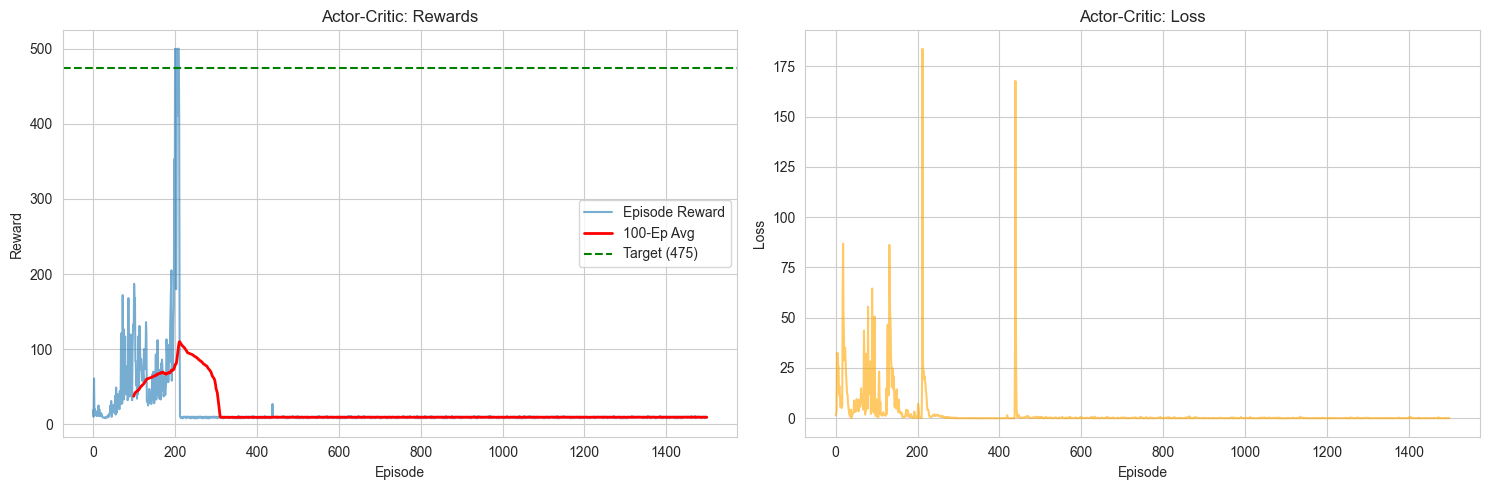

✓ Saved actor_critic to models/


In [16]:
# Analyze
plot_training_metrics(results_ac, "Actor-Critic", "results/actor_critic_training.png")
save_results(agent_ac, results_ac, "actor_critic")

---
# Section 4: Comparison

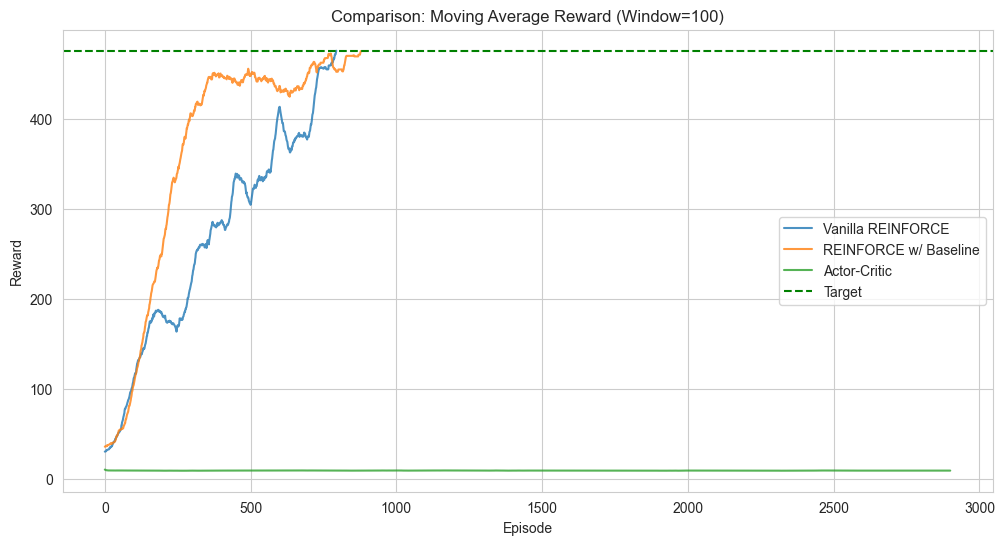

Vanilla Converged at: 894
Baseline Converged at: 978
Actor-Critic Converged at: 3000


In [ ]:
# Compare Rewards
plt.figure(figsize=(12, 6))

# Calculate moving averages
window = 100
r_reinforce = results_reinforce['rewards']
r_baseline = results_baseline['rewards']
r_ac = results_ac['rewards']

ma_reinforce = np.convolve(r_reinforce, np.ones(window)/window, mode='valid')
ma_baseline = np.convolve(r_baseline, np.ones(window)/window, mode='valid')
ma_ac = np.convolve(r_ac, np.ones(window)/window, mode='valid')

plt.plot(ma_reinforce, label='Vanilla REINFORCE', alpha=0.8)
plt.plot(ma_baseline, label='REINFORCE w/ Baseline', alpha=0.8)
plt.plot(ma_ac, label='Actor-Critic', alpha=0.8)

plt.axhline(y=475, color='green', linestyle='--', label='Target')
plt.title('Comparison: Moving Average Reward (Window=100)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.savefig("results/comparison.png")
plt.show()

print(f"Vanilla Converged at: {results_reinforce['episodes_trained']}")
print(f"Baseline Converged at: {results_baseline['episodes_trained']}")
print(f"Actor-Critic Converged at: {results_ac['episodes_trained']}")